In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import math
import jieba
import nltk
from nltk.corpus import stopwords
import string
from pprint import pprint
import pulp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gurobipy import Model, GRB, quicksum
import time
# pip install googletrans==4.0.0-rc1
from googletrans import Translator
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.tri as tri
from nltk import *
import pickle

C:\Users\huyushin\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\huyushin\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
C:\Users\huyushin\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Load the preporcessing phraes dictionary

In [2]:
with open('dictionary.pickle', 'rb') as f:
    dictionary = pickle.load(f)

print(list(dictionary.keys())[:5])
print(list(dictionary.values())[:5])

['machine learning', 'deep learning', 'artificial intelligence', 'big data', 'data mining']
['machineLearning', 'deepLearning', 'artificialIntelligence', 'bigData', 'dataMining']


Read the document and translate into english

In [3]:
# Read the document (already translate)
file_path = './_course1.csv' # file_path = './_course short.csv'
df_course = pd.read_csv(file_path)
df_course['Overview'] = df_course['Overview'].apply(lambda x: x.lower())
for i, v in df_course['Overview'].iteritems():
    temperary = v
    for d in dictionary:
        if d in v:
            temperary = temperary.replace(d, dictionary[d])
    df_course['Overview'].iloc[i] = temperary
    
# print(df_course.to_markdown())

In [ ]:
'''
# Read the document
file_path = './7250.csv' # '/content/drive/MyDrive/KG_OR/_course.csv'
df_course = pd.read_csv(file_path)
df_course.rename(columns={'ClassName': 'Name', 'classSummary': 'Overview'}, inplace=True)
df_course = df_course[['Name', 'Overview']]

# Translate into english
def translate_to_english(text):
    translator = Translator()
    try:
        translation = translator.translate(text, dest='en')
        return translation.text
    except Exception as e:
        print(f"Translation error: {e}")
        return text  # Return original text in case of an error

df_course['Name'] = df_course['Name'].apply(translate_to_english)
df_course['Overview'] = df_course['Overview'].apply(translate_to_english)
df_course['Overview'] = df_course['Overview'].apply(lambda x: x.lower())

# Save file
# file_path = '/home/huyushin/Downloads/7250_english.csv' # '/content/drive/MyDrive/KG_OR/_course.csv'
# df_course.to_csv(file_path, index=False)
'''

Process the document into words and word vectors

In [4]:
## Process the document into words and word vectors

# Generate the list of overviews: overview_li
name_li = df_course['Name'].tolist()
overview_li = df_course['Overview'].tolist()

# Pick up the words in overviews and remove stopwords: overviewwords_li
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.update(set(' '))
stemmer = stem.PorterStemmer()
def process_documents(overview): # Stopwords Removal
    tokens = jieba.lcut(overview)
    overviewwords = [stemmer.stem(word) for word in tokens if word not in stop_words and word not in string.punctuation]
    # overviewwords = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    return overviewwords
overviewwords_li = [process_documents(overview) for overview in overview_li]

# Generate the list of unique words: unique_overviewwords_li
unique_overviewwords_li = list(set(word for sublist in overviewwords_li for word in sublist))
print(f"Length of 'unique_overviewwords_li': {len(unique_overviewwords_li)}")

# Convert the unique words into vector space using Word2Vec: word_vectors
wv_trainli = unique_overviewwords_li + name_li
model = Word2Vec(sentences=[wv_trainli], vector_size=100, window=5, min_count=1, workers=4)
word_vectors = [model.wv[word] for word in unique_overviewwords_li]
print(f"Shape of 'word_vectors': {np.array(word_vectors).shape}")
model.save("your_word2vec_model.bin")
print('save')

# Generate 'sentence_events_before'
sentence_events_before = [{'trigger': name, 'elements': overviewwords} for name, overviewwords in zip(name_li, overviewwords_li)]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\huyushin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\huyushin\AppData\Local\Temp\jieba.cache
Loading model cost 1.939 seconds.
Prefix dict has been built successfully.


Length of 'unique_overviewwords_li': 120
Shape of 'word_vectors': (120, 100)
save


Generate parameters

In [5]:
## Generate parameters

# aij: number of times word i exists in document j
aij = [[overview.count(word) for overview in overviewwords_li] for word in unique_overviewwords_li]
aij = np.array(aij)
print(f"Shape of 'aij': {aij.shape}")

# bij: whether word i exists in document j
bij = [[1 if word in overview else 0 for overview in overviewwords_li] for word in unique_overviewwords_li]
bij = np.array(bij)
print(f"Shape of 'bij': {bij.shape}")

# inum: number of unique words
inum = len(unique_overviewwords_li)
print(f"Number of unique words 'inum': {inum}")

# jnum: number of documents
jnum = len(overviewwords_li)
print(f"Number of documents 'jnum': {jnum}")

# ti: whether word i appears in more than one document
ti = [1 if sum(occurrences) > 1 else 0 for occurrences in bij]
count_zero = ti.count(1)
print(f'Words appear in more than one document: {count_zero}')

'''
# sik: similarity between word i and k by calculating cosine similarity
sik = np.zeros((inum, inum)) # Find max_sik first
for i, word1 in enumerate(word_vectors):
    for k, word2 in enumerate(word_vectors):
        sik[i, k] = cosine_similarity([word1], [word2])[0][0]
max_sik = np.max(sik)
initial_value = 2 * max_sik # Since min problem, set invalid value as twice the max_sik
sik = np.full((inum, inum), initial_value)
for i, word1 in enumerate(word_vectors):
    for k, word2 in enumerate(word_vectors):
        sik[i, k] = 1 + (cosine_similarity([word1], [word2])[0][0])
#         sik[i, k] = abs(cosine_similarity([word1], [word2])[0][0])
#         sik[i, k] = cosine_similarity([word1], [word2])[0][0]
print(f"Shape of 'sik': {sik.shape}")

'''

# sik: similarity between word i and k by calculating minkowski distance
def minkowski_distance(X, Y, p=2):
    if len(X) != len(Y):
        raise ValueError("Both vectors must have the same length")
    distance = np.power(np.sum(np.power(np.abs(np.array(X) - np.array(Y)), p)), 1/p)
    return distance
sik = np.zeros((inum, inum)) # Find max_sik first
for i, word1 in enumerate(word_vectors):
    for k, word2 in enumerate(word_vectors):
        sik[i, k] = minkowski_distance(word1, word2, p=2)
max_sik = np.max(sik)
initial_value = 2 * max_sik # Since min problem, set invalid value as twice the max_sik
sik = np.full((inum, inum), initial_value)
for i, word1 in enumerate(word_vectors):
    for k, word2 in enumerate(word_vectors):
        sik[i, k] = minkowski_distance(word1, word2, p=2)
#         sik[i, k] = cosine_similarity([word1], [word2])[0][0]
print(f"Shape of 'sik': {sik.shape}")


Shape of 'aij': (120, 3)
Shape of 'bij': (120, 3)
Number of unique words 'inum': 120
Number of documents 'jnum': 3
Words appear in more than one document: 23
Shape of 'sik': (120, 120)


In [6]:
# See which words i appears in more than one document
for i, occurrences in enumerate(bij):
    word = unique_overviewwords_li[i]
    if sum(occurrences) > 1:
        print(f"'{word}': {occurrences}")

'manag': [1 1 0]
'knowledg': [1 1 0]
'effect': [1 0 1]
'cours': [1 1 1]
'system': [1 1 0]
'learn': [1 1 1]
'inform': [1 1 0]
'process': [0 1 1]
'student': [1 1 1]
'engin': [1 1 0]
'applic': [0 1 1]
'real': [1 1 1]
'manufactur': [1 1 0]
'design': [1 0 1]
'improv': [1 0 1]
'method': [0 1 1]
'appli': [1 1 0]
'solv': [1 1 1]
'use': [1 1 1]
'systemat': [1 1 0]
'problem': [1 1 1]
'domain': [1 1 0]
'integr': [1 1 0]


Optimize the objectives separately

In [7]:
## Optimize the objectives separately

from gurobipy import Model, GRB, quicksum

def optimize_separately(weight_tfidf, weight_wordnum, weight_sim):

    start_time = time.time()

    # Initialize model
    m = Model("multiOR")

    # Decision variables: xi, whether to choose word i in the knowledge graph
    xi = m.addVars([i for i in range(inum)], name="xi", vtype=GRB.BINARY)
    aij_xi_inv = m.addVars([j for j in range(jnum)], name="aij_xi_inv", vtype=GRB.CONTINUOUS)
    bij_xi_add1_inv_jnum = m.addVars([i for i in range(inum)], name="bij_xi_add1_inv_jnum", vtype=GRB.CONTINUOUS)
    tf_ij = m.addVars([(i, j) for i in range(inum) for j in range(jnum)], name="tf_ij", vtype=GRB.CONTINUOUS)
    idf_i = m.addVars([i for i in range(inum)], name="idf_i", vtype=GRB.CONTINUOUS)
    xi_xk = m.addVars([(i, k) for i in range(inum) for k in range(inum) if i != k], name="xi_xk", vtype=GRB.BINARY)

    # Objectives
    obj_tfidf = sum(tf_ij[i, j] * idf_i[i] for i in range(inum) for j in range(jnum))  # max
    obj_wordnum = - sum(xi[i] for i in range(inum))  # min
    obj_sim = - sum(sik[i, k] * xi_xk[i, k] for i in range(inum) for k in range(inum) if i != k)  # min

    obj_func = obj_tfidf * weight_tfidf + obj_wordnum * weight_wordnum + obj_sim * weight_sim
    m.setObjective(obj_func, GRB.MAXIMIZE)

    # Constraints: tf, idf
    for i in range(inum):
        for j in range(jnum):
            m.addConstr(tf_ij[i, j] == aij[i, j] * xi[i] * aij_xi_inv[j], "tf_ij")
            m.addGenConstrLog(bij_xi_add1_inv_jnum[i], idf_i[i]) # m.addGenConstrLog(z, u): u = log(z)

    # Constraints: denominators
    for i in range(inum):
        for j in range(jnum):
            m.addConstr(aij_xi_inv[j] * sum(aij[s, j] * xi[s] for s in range(inum)) == 1, "aij_xi_inv")

    # Constraints: xi_xk
    for i in range(inum):
        for k in range(inum):
            if i != k:
                m.addConstr(xi_xk[i, k] == xi[i] * xi[k], "xi_xk")

    # Constraints: at least choose jnum words
    m.addConstr(sum(xi[i] for i in range(inum)) >= jnum, "min_wordnum")

    # Constraints: keep words that can connect different documents
#     m.addConstrs((ti[i] >= xi[i] for i in range(inum)), "connect_words")

    # Optimizing the model
    m.params.NonConvex = 2
    m.setParam('OutputFlag', False)
    m.optimize()

    # Display the time duration
    print("===========================================================================================")
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Time duration: {execution_time}")

    # Check if the model has successfully optimized
    if m.status == GRB.OPTIMAL:
        # Extracting the values of decision variables
        xi_value = m.getAttr('x', xi)
        aij_xi_inv_value = m.getAttr('x', aij_xi_inv)
        bij_xi_add1_inv_jnum_value = m.getAttr('x', bij_xi_add1_inv_jnum)
        tf_ij_value = m.getAttr('x', tf_ij)
        idf_i_value = m.getAttr('x', idf_i)
        xi_xk_value = m.getAttr('x', xi_xk)

        # Display the results
        print(f"Optimal objective: {m.objVal:.3f}")
        non_zero_count = sum(1 for value in xi_value.values() if value != 0)
        print(f"Number of chosen words: {non_zero_count} / {inum}")
        print("=======================")
        obj_tfidf_value = sum(tf_ij_value[i, j] * idf_i_value[i] for i in range(inum) for j in range(jnum))
        obj_wordnum_value = -sum(xi_value[i] for i in range(inum))
        obj_sim_value = -sum(sik[i, k] * xi_xk_value[i, k] for i in range(inum) for k in range(inum) if i != k)
        print(f"obj_tfidf_value: {obj_tfidf_value:.3f}, with weight {weight_tfidf}")
        print(f"obj_wordnum_value: {obj_wordnum_value:.3f}, with weight {weight_wordnum}")
        print(f"obj_sim_value: {obj_sim_value:.3f}, with weight {weight_sim}")
        print("=======================")
        non_zero_indices = [index for index, value in xi_value.items() if value != 0]
        chosen_words = [unique_overviewwords_li[index] for index in non_zero_indices]
        print("Chosen words:")
        for word in chosen_words:
            print(word)

        return non_zero_count, m.objVal

    else:
        print("The model did not optimize successfully. Check the model and constraints.")
        return 0

# Calculate the maximum value for each objective separately (to help normalize)
words_countli = []
obj_maxli = []

weight_combinations = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
for weights in weight_combinations:
    words_counttemp, obj_maxtemp = optimize_separately(*weights)
    words_countli.append(words_counttemp)
    obj_maxli.append(abs(obj_maxtemp))

words_count_tfidf_max, words_count_wordnum_max, words_count_sim_max = words_countli
obj_tfidf_max, obj_wordnum_max, obj_sim_max = obj_maxli
print("===========================================================================================")
print(words_countli)
print(obj_maxli)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-06
Set parameter NonConvex to value 2
Time duration: 19.409417867660522
Optimal objective: 41.447
Number of chosen words: 7 / 120
obj_tfidf_value: 41.447, with weight 1
obj_wordnum_value: -4.000, with weight 0
obj_sim_value: -0.961, with weight 0
Chosen words:
knowledg
effect
decisionanalysi
vendor
model
facil
optim
Set parameter NonConvex to value 2
Time duration: 7.416404485702515
Optimal objective: -3.000
Number of chosen words: 3 / 120
obj_tfidf_value: 0.000, with weight 0
obj_wordnum_value: -3.000, with weight 1
obj_sim_value: -0.494, with weight 0
Chosen words:
practic
diagnost
javascript
Set parameter NonConvex to value 2
Time duration: 147.22243762016296
Optimal objective: -0.407
Number of chosen words: 3 / 120
obj_tfidf_value: 0.000, with weight 0
obj_wordnum_value: -3.000, with weight 0
obj_sim_value: -0.407, with weight 1
Chosen words:
design
multi
mobil
[7, 3, 3]
[41.446531673916475, 3.0

Perform normalized multi-objective optimizaiton

In [8]:
## Perform normalized multi-objective optimizaiton

start_time = time.time()

# Initialize model
m = Model("multiOR")

# Decision variables: xi, whether to choose word i in the knowledge graph
xi = m.addVars([i for i in range(inum)], name="xi", vtype=GRB.BINARY)
aij_xi_inv = m.addVars([j for j in range(jnum)], name="aij_xi_inv", vtype=GRB.CONTINUOUS)
bij_xi_add1_inv_jnum = m.addVars([i for i in range(inum)], name="bij_xi_add1_inv_jnum", vtype=GRB.CONTINUOUS)
tf_ij = m.addVars([(i, j) for i in range(inum) for j in range(jnum)], name="tf_ij", vtype=GRB.CONTINUOUS)
idf_i = m.addVars([i for i in range(inum)], name="idf_i", vtype=GRB.CONTINUOUS)
xi_xk = m.addVars([(i, k) for i in range(inum) for k in range(inum) if i != k], name="xi_xk", vtype=GRB.BINARY)

# Weights of objectives
weight_tfidf = 1/3
weight_wordnum = 1/3
weight_sim = 1 - weight_tfidf - weight_wordnum

weight_tfidf = 1
weight_wordnum = 0
weight_sim = 1 - weight_tfidf - weight_wordnum

# Objectives: Weighted-Sum method
# obj_tfidf = sum(tf_ij[i, j] * idf_i[i] for i in range(inum) for j in range(jnum))  # max
# obj_wordnum = - sum(xi[i] for i in range(inum))  # min
# obj_sim = - sum(sik[i, k] * xi_xk[i, k] for i in range(inum) for k in range(inum) if i != k)  # min
# normalized_obj_tfidf = obj_tfidf / obj_tfidf_max # *= (words_count_tfidf_max / obj_tfidf_max)
# normalized_obj_wordnum = obj_wordnum / obj_wordnum_max # *= (words_count_wordnum_max / obj_wordnum_max)
# normalized_obj_sim = obj_sim / obj_sim_max # *= (words_count_sim_max / obj_sim_max)
# obj_func = normalized_obj_tfidf * weight_tfidf + normalized_obj_wordnum * weight_wordnum + normalized_obj_sim * weight_sim
# m.setObjective(obj_func, GRB.MAXIMIZE)

# Objectives: Lp-Metric method
obj_tfidf = sum(tf_ij[i, j] * idf_i[i] for i in range(inum) for j in range(jnum))  # max
obj_wordnum = - sum(xi[i] for i in range(inum))  # min
obj_sim = - sum(sik[i, k] * xi_xk[i, k] for i in range(inum) for k in range(inum) if i != k)  # min
normalized_obj_tfidf = obj_tfidf - obj_tfidf_max / obj_tfidf_max # *= (words_count_tfidf_max / obj_tfidf_max)
normalized_obj_wordnum = obj_wordnum - obj_wordnum_max / obj_wordnum_max # *= (words_count_wordnum_max / obj_wordnum_max)
normalized_obj_sim = obj_sim - obj_sim_max / obj_sim_max # *= (words_count_sim_max / obj_sim_max)
obj_func = normalized_obj_tfidf * weight_tfidf + normalized_obj_wordnum * weight_wordnum + normalized_obj_sim * weight_sim
m.setObjective(obj_func, GRB.MAXIMIZE)

# Constraints: tf, idf
for i in range(inum):
    for j in range(jnum):
        m.addConstr(tf_ij[i, j] == aij[i, j] * xi[i] * aij_xi_inv[j], "tf_ij")
        m.addGenConstrLog(bij_xi_add1_inv_jnum[i], idf_i[i]) # m.addGenConstrLog(z, u): u = log(z)

# Constraints: denominators
for i in range(inum):
    for j in range(jnum):
        m.addConstr(aij_xi_inv[j] * sum(aij[s, j] * xi[s] for s in range(inum)) == 1, "aij_xi_inv")

# Constraints: xi_xk
for i in range(inum):
    for k in range(inum):
        if i != k:
            m.addConstr(xi_xk[i, k] == xi[i] * xi[k], "xi_xk")

# Constraints: at least choose jnum words
m.addConstr(sum(xi[i] for i in range(inum)) >= jnum+1, "min_wordnum")

# Constraints: keep words that can connect different documents
# m.addConstrs((ti[i] >= xi[i] for i in range(inum)), "connect_words")

# Optimizing the model
m.params.NonConvex = 2
m.setParam('OutputFlag', False)
m.optimize()

# Display the time duration
print("===========================================================================================")
end_time = time.time()
execution_time = end_time - start_time
print(f"Time duration: {execution_time}")

# Check if the model has successfully optimized
if m.status == GRB.OPTIMAL:
    # Extracting the values of decision variables
    xi_value = m.getAttr('x', xi)
    aij_xi_inv_value = m.getAttr('x', aij_xi_inv)
    bij_xi_add1_inv_jnum_value = m.getAttr('x', bij_xi_add1_inv_jnum)
    tf_ij_value = m.getAttr('x', tf_ij)
    idf_i_value = m.getAttr('x', idf_i)
    xi_xk_value = m.getAttr('x', xi_xk)

    # Display the results
    print(f"Optimal objective: {m.objVal:.3f}")
    non_zero_count = sum(1 for value in xi_value.values() if value != 0)
    print(f"Number of chosen words: {non_zero_count} / {inum}")
    print("=======================")
    obj_tfidf_value = sum(tf_ij_value[i, j] * idf_i_value[i] for i in range(inum) for j in range(jnum))
    obj_wordnum_value = -sum(xi_value[i] for i in range(inum))
    obj_sim_value = -sum(sik[i, k] * xi_xk_value[i, k] for i in range(inum) for k in range(inum) if i != k)
    print(f"obj_tfidf_value: {obj_tfidf_value:.3f}, with weight {weight_tfidf:.1f}, normalized_obj_tfidf_value: {obj_tfidf_value / obj_tfidf_max:.3f} with max {obj_tfidf_max:.3f}")
    print(f"obj_wordnum_value: {obj_wordnum_value:.3f}, with weight {weight_wordnum:.1f}, normalized_obj_wordnum_value: {obj_wordnum_value / obj_wordnum_max:.3f} with max {obj_wordnum_max:.3f}")
    print(f"obj_sim_value: {obj_sim_value:.3f}, with weight {weight_sim:.1f}, normalized_obj_sim_value: {obj_sim_value / obj_sim_max:.3f} with max {obj_sim_max:.3f}")
    print("===========================================================================================")
    non_zero_indices = [index for index, value in xi_value.items() if value != 0]
    chosen_words = [unique_overviewwords_li[index] for index in non_zero_indices]
    print("Chosen words:")
    for word in chosen_words:
        print(word)

Set parameter NonConvex to value 2
Time duration: 15.675934314727783
Optimal objective: 40.447
Number of chosen words: 10 / 120
obj_tfidf_value: 41.447, with weight 1.0, normalized_obj_tfidf_value: 1.000 with max 41.447
obj_wordnum_value: -10.000, with weight 0.0, normalized_obj_wordnum_value: -3.333 with max 3.000
obj_sim_value: -7.171, with weight 0.0, normalized_obj_sim_value: -17.624 with max 0.407
Chosen words:
practic
support
know
financi
final
develop
integr
facil
optim
javascript


Plot an event connectivity knowledge graph

{'trigger': 'Manufacturing Data Science', 'elements': ['support', 'integr']}
{'trigger': 'Operations Research Applications and Implementation ', 'elements': ['practic', 'know', 'financi', 'final', 'develop', 'integr', 'facil', 'optim']}
{'trigger': 'Web Application Programming', 'elements': ['javascript']}


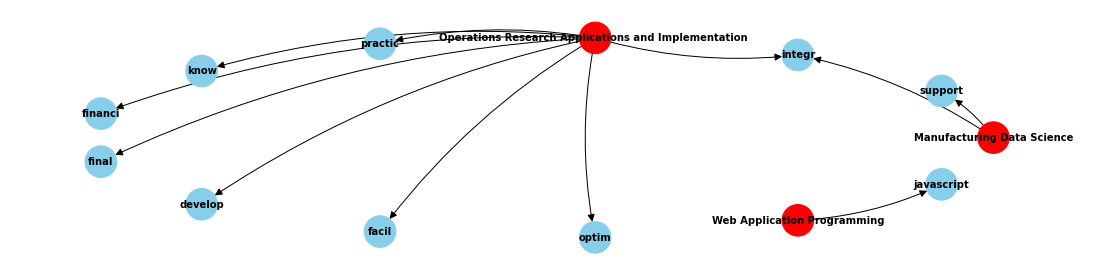

In [9]:
## Plot an event connectivity knowledge graph

# bij_xi_value: whether word i exists in the document j
bij_xi_value = {(s, j): bij[s, j] * xi_value[s] for j in range(jnum) for s in range(inum)}

# Construct 'sentence_events_after'
trigger_elements_map = defaultdict(list)
for j in range(jnum):
    for i in range(inum):
        if bij_xi_value[(i, j)] != 0:
            trigger_elements_map[name_li[j]].append(unique_overviewwords_li[i])
sentence_events_after = [{"trigger": trigger, "elements": elements} for trigger, elements in trigger_elements_map.items()]
for event in sentence_events_after:
    print(event)
sentence_events_after = sentence_events_after.copy()

# Construct knowledge graph
knowledge_graph = nx.DiGraph()
for event in sentence_events_after:
    trigger = event['trigger']
    elements = event['elements']
    knowledge_graph.add_node(trigger, color='red')
    for element in elements:
        knowledge_graph.add_node(element)
        knowledge_graph.add_edge(trigger, element)

# Plot knowledge graph
plt.figure(figsize=(15, 3.5))
# pos = nx.spring_layout(knowledge_graph)
# pos = nx.shell_layout(knowledge_graph)
pos = nx.circular_layout(knowledge_graph)
# pos = nx.kamada_kawai_layout(knowledge_graph)
node_colors = [data.get('color', 'skyblue') for node, data in knowledge_graph.nodes(data=True)]
nx.draw(knowledge_graph, pos, with_labels=True, font_size=10, node_size=1000, node_color=node_colors, font_color='black', font_weight='bold', arrowsize=15, connectionstyle='arc3,rad=0.1')
plt.show()


Parallel 3D Pareto frontier

In [ ]:
## Compute the Pareto frontier

def optimize_pareto(weight_tfidf, weight_wordnum, weight_sim):

    start_time = time.time()

    # Initialize model
    m = Model("multiOR")

    # Decision variables: xi, whether to choose word i in the knowledge graph
    xi = m.addVars([i for i in range(inum)], name="xi", vtype=GRB.BINARY)
    aij_xi_inv = m.addVars([j for j in range(jnum)], name="aij_xi_inv", vtype=GRB.CONTINUOUS)
    bij_xi_add1_inv_jnum = m.addVars([i for i in range(inum)], name="bij_xi_add1_inv_jnum", vtype=GRB.CONTINUOUS)
    tf_ij = m.addVars([(i, j) for i in range(inum) for j in range(jnum)], name="tf_ij", vtype=GRB.CONTINUOUS)
    idf_i = m.addVars([i for i in range(inum)], name="idf_i", vtype=GRB.CONTINUOUS)
    xi_xk = m.addVars([(i, k) for i in range(inum) for k in range(inum) if i != k], name="xi_xk", vtype=GRB.BINARY)

    # Objectives
    obj_tfidf = sum(tf_ij[i, j] * idf_i[i] for i in range(inum) for j in range(jnum))  # max
    obj_wordnum = - sum(xi[i] for i in range(inum))  # min
    obj_sim = - sum(sik[i, k] * xi_xk[i, k] for i in range(inum) for k in range(inum) if i != k)  # min

    obj_func = obj_tfidf * weight_tfidf + obj_wordnum * weight_wordnum + obj_sim * weight_sim
    m.setObjective(obj_func, GRB.MAXIMIZE)

    # Constraints: tf, idf
    for i in range(inum):
        for j in range(jnum):
            m.addConstr(tf_ij[i, j] == aij[i, j] * xi[i] * aij_xi_inv[j], "tf_ij")
            m.addGenConstrLog(bij_xi_add1_inv_jnum[i], idf_i[i]) # m.addGenConstrLog(z, u): u = log(z)

    # Constraints: denominators
    for i in range(inum):
        for j in range(jnum):
            m.addConstr(aij_xi_inv[j] * sum(aij[s, j] * xi[s] for s in range(inum)) == 1, "aij_xi_inv")

    # Constraints: xi_xk
    for i in range(inum):
        for k in range(inum):
            if i != k:
                m.addConstr(xi_xk[i, k] == xi[i] * xi[k], "xi_xk")

    # Constraints: at least choose jnum words
    m.addConstr(sum(xi[i] for i in range(inum)) >= jnum, "min_wordnum")

    # Constraints: keep words that can connect different documents
#     m.addConstrs((ti[i] >= xi[i] for i in range(inum)), "connect_words")

    # Optimizing the model
    m.params.NonConvex = 2
    m.setParam('OutputFlag', False)
    m.optimize()

    # Display the time duration
    print("===========================================================================================")
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Time duration: {execution_time}")

    # Check if the model has successfully optimized
    if m.status == GRB.OPTIMAL:
        # Extracting the values of decision variables
        xi_value = m.getAttr('x', xi)
        aij_xi_inv_value = m.getAttr('x', aij_xi_inv)
        bij_xi_add1_inv_jnum_value = m.getAttr('x', bij_xi_add1_inv_jnum)
        tf_ij_value = m.getAttr('x', tf_ij)
        idf_i_value = m.getAttr('x', idf_i)
        xi_xk_value = m.getAttr('x', xi_xk)

        # Display the results
        print(f"Optimal objective: {m.objVal:.3f}")
        non_zero_count = sum(1 for value in xi_value.values() if value != 0)
        print(f"Number of chosen words: {non_zero_count} / {inum}")
        print("=======================")
        obj_tfidf_value = sum(tf_ij_value[i, j] * idf_i_value[i] for i in range(inum) for j in range(jnum))
        obj_wordnum_value = -sum(xi_value[i] for i in range(inum))
        obj_sim_value = -sum(sik[i, k] * xi_xk_value[i, k] for i in range(inum) for k in range(inum) if i != k)
        print(f"obj_tfidf_value: {obj_tfidf_value:.3f}, with weight {weight_tfidf}")
        print(f"obj_wordnum_value: {obj_wordnum_value:.3f}, with weight {weight_wordnum}")
        print(f"obj_sim_value: {obj_sim_value:.3f}, with weight {weight_sim}")
        print("=======================")
        non_zero_indices = [index for index, value in xi_value.items() if value != 0]
        chosen_words = [unique_overviewwords_li[index] for index in non_zero_indices]
        print("Chosen words:")
        for word in chosen_words:
            print(word)

        return obj_tfidf_value, obj_wordnum_value, obj_sim_value

    else:
        print("The model did not optimize successfully. Check the model and constraints.")
        return 0

# Generate weights_combinations
n = 3 # slices
weights_combinations = []
for i in range(n + 1):
    for j in range(n + 1 - i):
        k = n - i - j
        # Normalized into a weighted combination that sums to 1
        weight_tfidf = i / n
        weight_wordnum = j / n
        weight_sim = k / n
        weights_combinations.append((weight_tfidf, weight_wordnum, weight_sim))
print(len(weights_combinations))

obj_tfidf_values = []
obj_wordnum_values = []
obj_sim_values = []

for weights in weight_combinations:
    obj_tfidf_value, obj_wordnum_value, obj_sim_value = optimize_pareto(*weights)
    obj_tfidf_values.append(obj_tfidf_value)
    obj_wordnum_values.append(obj_wordnum_value)
    obj_sim_values.append(obj_sim_value)

10
Set parameter NonConvex to value 2
Time duration: 16.544860124588013
Optimal objective: 41.447
Number of chosen words: 7 / 120
obj_tfidf_value: 41.447, with weight 1
obj_wordnum_value: -4.000, with weight 0
obj_sim_value: -0.961, with weight 0
Chosen words:
knowledg
effect
decisionanalysi
vendor
model
facil
optim
Set parameter NonConvex to value 2
Time duration: 8.13079023361206
Optimal objective: -3.000
Number of chosen words: 3 / 120
obj_tfidf_value: 0.000, with weight 0
obj_wordnum_value: -3.000, with weight 1
obj_sim_value: -0.494, with weight 0
Chosen words:
practic
diagnost
javascript
Set parameter NonConvex to value 2


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# Create a DataFrame from the lists
df = pd.DataFrame({
    'TF-IDF': obj_tfidf_values,
    'WordNum': obj_wordnum_values,
    'Similarity': obj_sim_values,
})

# Create the parallel coordinates plot
plt.figure(figsize=(10, 6))
parallel_coordinates(df, class_column='Class', colormap=plt.get_cmap("Set2"))
plt.xlabel('Objectives')
plt.ylabel('Values')
plt.title('Parallel Coordinates Plot for Multi-Objective Optimization')
plt.show()
